In [1]:
from scripts.get_data import get_processed_data
from scripts.models import VotingClassifier

In [2]:
# logistic regression
from sklearn.linear_model import LogisticRegression 
# elastic net 
from sklearn.linear_model import ElasticNet
# svm classifier
from sklearn.svm import SVC
# lda 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [3]:
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif

data, labels = get_processed_data(corr_thresh=0.9, minmax_scale=True, var_thresh=0.01, k_to_select=1000)

In [4]:
from timeit import default_timer as timer   

## Ensemble model

This uses an implementation of the ensemble model as described in the paper. This is so that we can use this as a baseline to make comparisons.

In [5]:
model = VotingClassifier(20, SVC(kernel='linear'))
model.train(data.values, labels)
predictions = model.predict(data.values)

In [6]:
from sklearn.metrics import mean_absolute_error, accuracy_score

mean_absolute_error(labels, predictions), accuracy_score(labels, predictions)

(0.0, 1.0)

We have 100% accuracy on the training data when the `N` different models are all `SVC()`. 

## Leave One Out scoring

In [12]:
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_absolute_error, median_absolute_error
from sklearn.ensemble import RandomForestClassifier

splitter = LeaveOneOut()
true_labels = []
pred_labels = []
# min_impurity_split has been removed as of sklearn 0.23.2, so we use min_samples_leaf instead
base_estimator = RandomForestClassifier(n_estimators=100, min_samples_leaf=2) 
# base_estimator = LogisticRegression()
train_time, eval_time = 0.0, 0.0

for fold, (train_ind, val_ind) in enumerate(splitter.split(data)):
    model = VotingClassifier(20, base_estimator)
    # model = LinearRegression()
    # model = LogisticRegression()
    # model = LDA(solver='eigen', shrinkage='auto')
    train_timer = timer()
    model.train(data.iloc[train_ind], labels.iloc[train_ind])
    train_time += timer() - train_timer
    eval_timer = timer()
    pred = model.predict(data.iloc[val_ind]).reshape(-1,)
    eval_time += timer() - eval_timer
    true_labels.append(labels.iloc[val_ind].values[0])
    pred_labels.append(pred[0])
    print(f'[Fold {fold+1}/{splitter.get_n_splits(data)}] ==> True label: {true_labels[-1]}, Prediction: {pred_labels[-1]}')

print(f'Average train time: {(train_time / splitter.get_n_splits(data)):.6f} s, average eval time: {(eval_time / splitter.get_n_splits(data)):.6f} s')

[Fold 1/133] ==> True label: 19, Prediction: 26
[Fold 2/133] ==> True label: 19, Prediction: 25
[Fold 3/133] ==> True label: 19, Prediction: 22
[Fold 4/133] ==> True label: 19, Prediction: 22
[Fold 5/133] ==> True label: 20, Prediction: 23
[Fold 6/133] ==> True label: 20, Prediction: 31
[Fold 7/133] ==> True label: 31, Prediction: 16
[Fold 8/133] ==> True label: 31, Prediction: 32
[Fold 9/133] ==> True label: 32, Prediction: 31
[Fold 10/133] ==> True label: 32, Prediction: 31
[Fold 11/133] ==> True label: 33, Prediction: 12
[Fold 12/133] ==> True label: 33, Prediction: 23
[Fold 13/133] ==> True label: 37, Prediction: 30
[Fold 14/133] ==> True label: 37, Prediction: 31
[Fold 15/133] ==> True label: 37, Prediction: 31
[Fold 16/133] ==> True label: 39, Prediction: 19
[Fold 17/133] ==> True label: 51, Prediction: 70
[Fold 18/133] ==> True label: 52, Prediction: 29
[Fold 19/133] ==> True label: 55, Prediction: 25
[Fold 20/133] ==> True label: 57, Prediction: 40
[Fold 21/133] ==> True label:

In [13]:
import numpy as np

mean_error = mean_absolute_error(np.array(true_labels), np.array(pred_labels))
median_error = median_absolute_error(np.array(true_labels), np.array(pred_labels))
mean_error, median_error

(10.992481203007518, 6.0)

In [14]:
from sklearn.metrics import r2_score

r2 = r2_score(np.array(true_labels), np.array(pred_labels))
r2

0.60559780349058

Text(0, 0.5, 'Predictions')

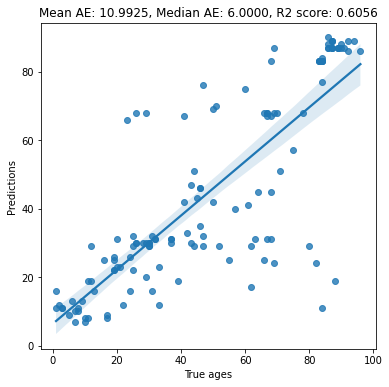

In [15]:
from seaborn import regplot
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
regplot(x=true_labels, y=pred_labels)
plt.title(f'Mean AE: {mean_error:.4f}, Median AE: {median_error:.4f}, R2 score: {r2:.4f}')
plt.xlabel('True ages')
plt.ylabel('Predictions')